# 2 Labelling Stock Relevances

## 2.1 Imports and Dataset Load

In [1]:
# General DS Purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override() # bypassing default pandas_datareader with yfinance Y! API implementation

# Zipfile Support
import glob
import zipfile

#Exports for future use
import pickle

In [3]:
# catch the most recent zip file
lst_zip_files = glob.glob('data/config/*price_comp*zip') # * means all if need specific format then *.csv
latest_zip_file = max(lst_zip_files, key=os.path.getctime)  
zf = zipfile.ZipFile(latest_zip_file)

In [4]:
# looks for good composition (In Review for Further Checks)
try:
    tickers = pd.read_csv(zf.open("tickers.csv"), usecols=[1]).loc[:,"0"].tolist()
except:
    raise Exception("Sorry. ZIP file with bad structure.")    

In [5]:
csv_files_excluded = ["tickers.csv", "skips_alltimes.csv", "sp500_components_cached.csv"]
data_dict = {f.strip(".csv"): pd.read_csv(zf.open(f), index_col="date", parse_dates=True)["close"].pct_change() for f in zf.namelist() if f not in csv_files_excluded}

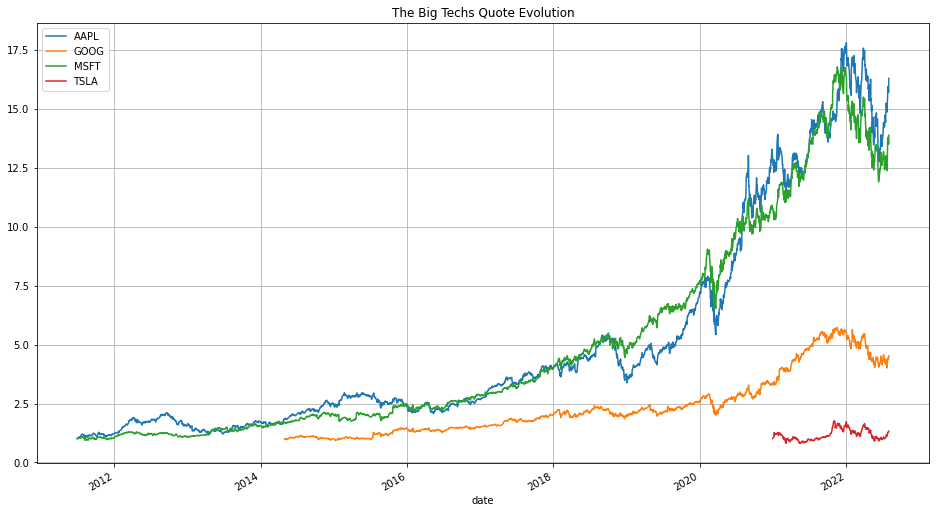

In [6]:
# testing Gross Returns Evolution ($AAPL and other BigTechs Equity Lines shown)
(1+data_dict["AAPL"]).rename("AAPL").cumprod().plot(figsize=(16,9), title="The Big Techs Quote Evolution", legend=True)
(1+data_dict["GOOG"]).rename("GOOG").cumprod().plot(legend=True)
(1+data_dict["MSFT"]).rename("MSFT").cumprod().plot(legend=True)
# New Kid on The Block (TSLA)
(1+data_dict["TSLA"]).rename("TSLA").cumprod().plot(legend=True); # joins SP500 since 2021
plt.grid();

## Resampling Raw Daily Returns

In [7]:
df = pd.DataFrame(data_dict)
df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,0.010279,0.002528,NaN,NaN,0.004879,NaN,0.007544,NaN,0.008819,NaN,...,0.014655,0.015610,NaN,NaN,0.000181,0.008779,NaN,-0.003321,NaN,NaN
2011-07-01,0.017414,0.028373,NaN,NaN,0.022612,NaN,0.017392,NaN,0.009122,NaN,...,0.011555,0.028818,NaN,NaN,0.027335,0.029905,NaN,0.017076,NaN,NaN
2011-07-05,-0.006539,0.004905,NaN,NaN,0.017975,NaN,0.003799,NaN,0.001130,NaN,...,0.001038,-0.013071,NaN,NaN,-0.002643,-0.010294,NaN,-0.013104,NaN,NaN
2011-07-06,0.003098,-0.009152,NaN,NaN,0.006668,NaN,0.019158,NaN,0.002257,NaN,...,0.007520,0.000000,NaN,NaN,-0.007951,0.002018,NaN,-0.002490,NaN,NaN


In [8]:
def net_cumreturn(data, last_row=False):
    df = ((1+data).cumprod(axis=0)-1)
    if last_row:
        return df.iloc[-1]
    return df

df["AAPL"].resample("BM").apply(net_cumreturn, last_row=True)[:-1] # (Net) Cumulative Return and Monthly Resampling

date
2011-06-30    0.004879
2011-07-29    0.163286
2011-08-31   -0.007462
2011-09-30   -0.009121
2011-10-31    0.054028
                ...   
2022-03-31    0.054457
2022-04-29   -0.097131
2022-05-31   -0.054496
2022-06-30   -0.081430
2022-07-29    0.188634
Freq: BM, Name: AAPL, Length: 134, dtype: float64

After test with `AAPL` let's try with the entire dataframe

In [9]:
df_monthly_returns = df.resample("BM").apply(net_cumreturn, last_row=True)[1:-1]

In [10]:
df_monthly_returns.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,-0.175113,-0.071248,NaN,NaN,0.163286,NaN,-0.074638,NaN,-0.015840,NaN,...,-0.004989,-0.103747,NaN,NaN,-0.039461,-0.050316,NaN,-0.087880,NaN,NaN
2011-08-31,-0.125474,-0.124954,NaN,NaN,-0.007462,NaN,0.036231,NaN,0.031832,NaN,...,-0.070996,-0.120673,NaN,NaN,0.029345,-0.052149,NaN,-0.203123,NaN,NaN
2011-09-30,-0.152428,-0.252344,NaN,NaN,-0.009121,NaN,-0.058363,NaN,-0.026091,NaN,...,-0.126710,-0.155444,NaN,NaN,-0.091595,-0.059940,NaN,-0.192661,NaN,NaN
2011-10-31,0.186240,0.124347,NaN,NaN,0.054028,NaN,0.094714,NaN,0.063066,NaN,...,0.204301,0.173601,NaN,NaN,0.090623,-0.015894,NaN,0.232955,NaN,NaN
2011-11-30,0.011599,-0.070590,NaN,NaN,-0.055783,NaN,-0.086342,NaN,0.004140,NaN,...,-0.022998,0.007976,0.027074,NaN,0.046108,-0.039521,NaN,-0.072600,NaN,NaN


In [11]:
df_monthly_returns.tail()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,0.015112,NaN,0.057971,0.019498,0.054457,0.077717,0.085456,0.065972,-0.026957,NaN,...,-0.088573,NaN,-0.041484,NaN,-0.028248,0.040084,0.000871,-0.075187,NaN,-0.026130
2022-04-29,-0.097278,NaN,0.028493,-0.035418,-0.097131,-0.086248,-0.022106,-0.134827,-0.037239,NaN,...,-0.187525,NaN,-0.052360,NaN,-0.017692,-0.058033,-0.106454,-0.138042,NaN,-0.058485
2022-05-31,0.069506,NaN,-0.047949,-0.048941,-0.054496,0.003336,0.026248,-0.079838,0.034890,NaN,...,-0.010753,NaN,0.046584,NaN,0.043261,-0.004472,-0.085132,0.016414,NaN,-0.035656
2022-06-30,-0.068909,NaN,-0.290431,-0.080321,-0.081430,0.049010,-0.085987,-0.061396,-0.070893,NaN,...,-0.093626,NaN,-0.072047,NaN,-0.065531,-0.124054,-0.130814,-0.107644,NaN,0.005616
2022-07-29,0.131073,NaN,0.081230,0.118609,0.188634,-0.063006,0.031453,0.183831,0.001749,NaN,...,0.012035,NaN,0.177155,NaN,0.079552,0.050733,0.216840,0.071709,NaN,0.063965


A very useful graphical comparison between types of compounding wealth invested depending on sampling frequency

In [13]:
df_monthly_returns.shape

(133, 755)

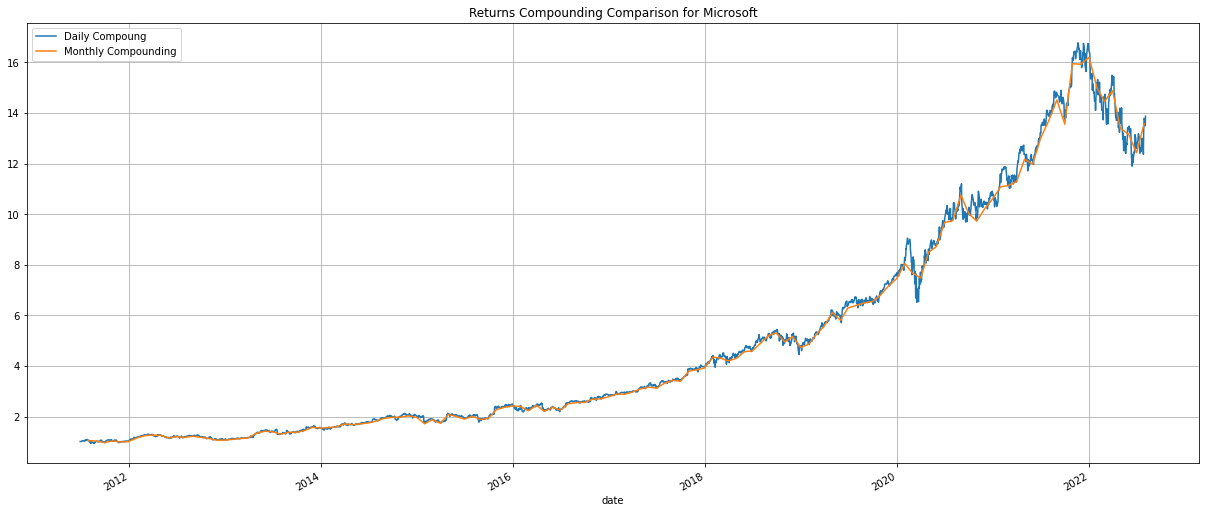

In [12]:
(1+df["MSFT"]).cumprod().rename("Daily Compoung").plot(legend=True)
(1+df_monthly_returns["MSFT"]).cumprod().rename("Monthly Compounding").plot(legend=True, title="Returns Compounding Comparison for Microsoft", figsize=(21,9))
plt.grid();


## Ranking Assets By Monthly Raw Returns Each End Of Month

1) Ranking for each business month end frequency (_BM_). From **LTR** algos perspective, index could be used as a _query_ label:

In [14]:
df_monthly_returns.rank(axis=1) # The Higher Rank, The Higher Return

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,13.0,132.0,NaN,NaN,470.0,NaN,121.0,NaN,301.0,NaN,...,336.0,55.0,NaN,NaN,212.0,191.0,NaN,91.0,NaN,NaN
2011-08-31,101.0,102.0,NaN,NaN,357.0,NaN,430.0,NaN,422.0,NaN,...,208.0,107.0,NaN,NaN,418.0,251.0,NaN,24.0,NaN,NaN
2011-09-30,107.0,21.0,NaN,NaN,399.0,NaN,292.0,NaN,360.0,NaN,...,152.0,101.0,NaN,NaN,216.0,290.0,NaN,60.0,NaN,NaN
2011-10-31,351.0,239.0,NaN,NaN,94.0,NaN,169.0,NaN,118.0,NaN,...,374.0,336.0,NaN,NaN,163.0,17.0,NaN,407.0,NaN,NaN
2011-11-30,298.0,68.0,NaN,NaN,93.0,NaN,48.0,NaN,272.0,NaN,...,176.0,281.0,343.0,NaN,397.0,122.0,NaN,63.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,226.0,NaN,320.0,236.0,311.0,373.0,386.0,348.0,125.0,NaN,...,40.0,NaN,101.0,NaN,122.0,281.0,190.0,56.0,NaN,129.0
2022-04-29,156.0,NaN,443.0,328.0,157.0,181.0,353.0,87.0,324.0,NaN,...,33.0,NaN,284.0,NaN,362.0,268.0,138.0,83.0,NaN,267.0
2022-05-31,410.0,NaN,95.0,93.0,89.0,232.0,307.0,55.0,329.0,NaN,...,197.0,NaN,359.0,NaN,351.0,214.0,52.0,269.0,NaN,122.0


#### Some Useful Checks

In [35]:
top10_ranks = df_monthly_returns.rank(axis=1).iloc[0].sort_values(ascending=False).head(24) # First End-Of-Month Ranking

In [36]:
top10_monthly_rets = df_monthly_returns.iloc[0].sort_values(ascending=False).head(24)

In [39]:
top24 = pd.concat([top10_ranks, top10_monthly_rets], axis=1, join="inner") # The correct ordering (as expected)

Let us **construct a minimal viable scorer** (function `def()` moved to a python module):

In [63]:
from modules import performance_measures_helper as pms
# 20 categories by default
df_stock_scores = df_monthly_returns.rank(axis=1).apply(pms.scorer, axis=1)

In [64]:
top_category = df_stock_scores.iloc[0].sort_values(ascending=False).head(24)

In [65]:
pd.concat([top24, top_category], join="inner", axis=1)

,2011-07-29,2011-07-29,2011-07-29
WPI,476.0,0.428571,20.0
CVC,475.0,0.315244,20.0
EQT,474.0,0.208683,20.0
GOOGL,473.0,0.192168,20.0
RRC,472.0,0.174054,20.0
APOL,471.0,0.163690,20.0
AAPL,470.0,0.163286,20.0
CHK,469.0,0.157164,20.0
URBN,468.0,0.155950,20.0
ETFC,467.0,0.150725,20.0


In [ ]:
# notna values. This implies trading with a different number of high relevant (CAT 1) and high irrelevant (CAT 20) stocks on each "query" date
""" def revelator(data): #John, The Revelator (Moved to `performance_measures_helper.py`)
    bins = 20
    df = pd.cut(x=data, bins=bins, labels=False)
    return 1+df """

In [67]:
df_stock_scores = df_stock_scores.shift(-1)
df_stock_scores

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,5.0,5.0,NaN,NaN,16.0,NaN,19.0,NaN,18.0,NaN,...,9.0,5.0,NaN,NaN,18.0,11.0,NaN,1.0,NaN,NaN
2011-08-31,5.0,1.0,NaN,NaN,17.0,NaN,13.0,NaN,16.0,NaN,...,7.0,5.0,NaN,NaN,10.0,13.0,NaN,3.0,NaN,NaN
2011-09-30,15.0,11.0,NaN,NaN,4.0,NaN,8.0,NaN,5.0,NaN,...,16.0,15.0,NaN,NaN,7.0,1.0,NaN,18.0,NaN,NaN
2011-10-31,13.0,3.0,NaN,NaN,4.0,NaN,2.0,NaN,12.0,NaN,...,8.0,12.0,15.0,NaN,17.0,6.0,NaN,3.0,NaN,NaN
2011-11-30,3.0,1.0,NaN,NaN,18.0,NaN,9.0,NaN,13.0,NaN,...,6.0,8.0,19.0,NaN,17.0,17.0,NaN,10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,7.0,NaN,18.0,14.0,7.0,8.0,15.0,4.0,13.0,NaN,...,2.0,NaN,12.0,NaN,15.0,11.0,6.0,4.0,NaN,11.0
2022-04-29,17.0,NaN,4.0,4.0,4.0,10.0,13.0,3.0,14.0,NaN,...,8.0,NaN,15.0,NaN,14.0,9.0,3.0,11.0,NaN,5.0
2022-05-31,12.0,NaN,1.0,12.0,11.0,20.0,11.0,13.0,12.0,NaN,...,10.0,NaN,12.0,NaN,13.0,7.0,6.0,8.0,NaN,19.0


In [68]:
""" 
Relevance encoding must be lagged : to train the model we have to calculate and select features 
capable to explain the one-period (1 BM) after high or low performance
In this way relevances can be inferred by the model on the test set (prediction) 
and then implement portfolio selection policies prior to the period of interest 
"""
df_stock_scores.to_csv("data/config/20220831_monthly_stock_scores.csv", na_rep="#N/A", index=True, index_label="Date")

#### Signalling By Category: Long Only Category-based PFolios

**Categorized Long Only portfolio strategies versus Baseline Portfolio (SP500 replica with Low-Survivorship-Bias)**

In [70]:
df_monthly_returns.shape
df_stock_scores.shape

(133, 755)

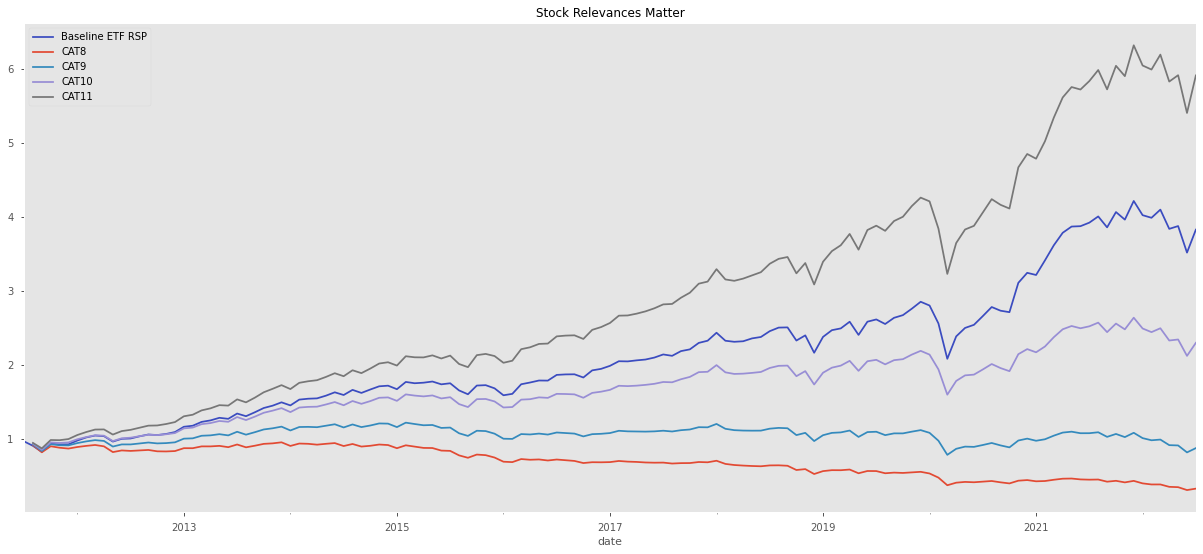

In [80]:
plt.style.use("seaborn-notebook")

plt_kwds = {
    "legend": True,
    "figsize": (21,9),
    "title": "Stock Relevances Matter"
}

# Baseline ETF biased Replica (0.2% fee p.a.)
(1+df_monthly_returns.mean(axis=1,skipna=True)+0.002/12).rename("Baseline ETF RSP").cumprod().plot(**plt_kwds, cmap="coolwarm")
plt.grid();

# CAT10 ("Median" Category)
for cat in range(8,12):
    mask = df_stock_scores.shift(1)==cat
    (1+df_monthly_returns[mask].mean(axis=1,skipna=True)).rename("CAT"+str(cat)).cumprod().plot(**plt_kwds)

plt.grid();

In [230]:
df_stock_scores.iloc[-2].value_counts()

10.0    26
1.0     26
20.0    26
19.0    25
5.0     25
15.0    25
8.0     25
14.0    25
17.0    25
13.0    25
6.0     25
11.0    25
12.0    25
3.0     25
9.0     25
18.0    25
16.0    25
2.0     25
7.0     25
4.0     25
Name: 2022-06-30 00:00:00, dtype: int64

**Finally** A toy strategy longing better performers than the median (CAT10) and shorting worst performers (CAT12):
_Fees_, _Actual Margin Brokerage Accounts_ and _Organized Markets Restrictions (such as short positions banned)_ are not taken into account.

Obviously this is a TOY trading program. We don't know a priori stock relevances and precisely for that we are intending to use **LTR Machine Learning** in order to _anticipate_ (via training these **LTR** models) the correct a __posteriori relevances__ (a good and profitable behaviour in test sets).

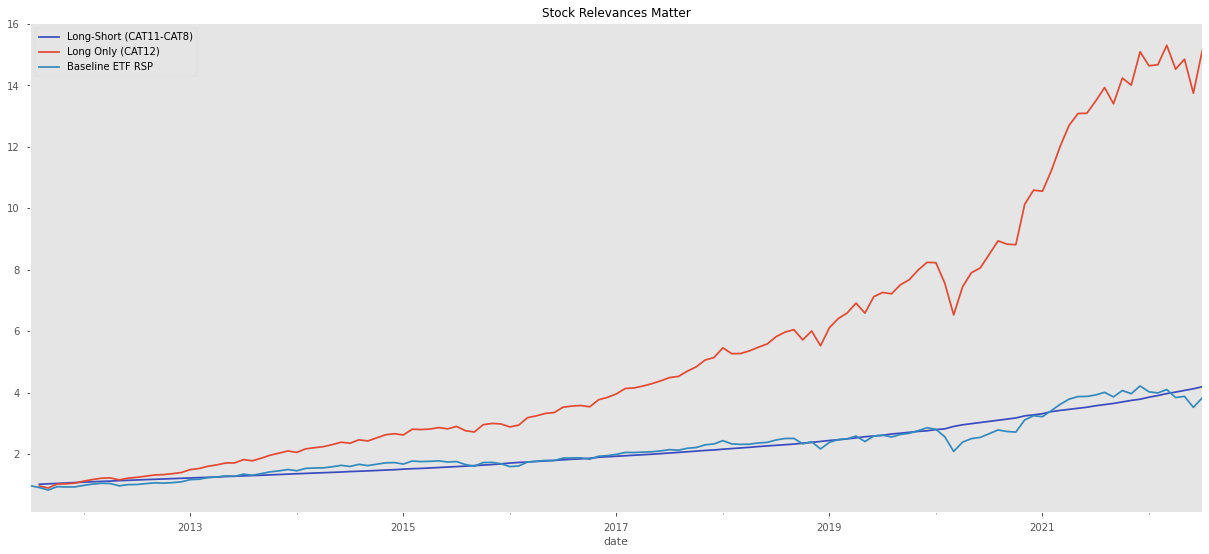

In [86]:
mask8 = (df_stock_scores.shift(1)==8)
mask11 = (df_stock_scores.shift(1)==11)
mask12 = (df_stock_scores.shift(1)==12)

(
    (1-0.5*df_monthly_returns[mask8].mean(axis=1, skipna=True)+0.5*df_monthly_returns[mask11].mean(axis=1, skipna=True)).rename("Long-Short (CAT11-CAT8)")
    .cumprod()
    .plot(**plt_kwds, cmap="coolwarm")
)
(1+df_monthly_returns[mask11].mean(axis=1, skipna=True)).rename("Long Only (CAT11)").cumprod().plot(**plt_kwds)

(1+df_monthly_returns.mean(axis=1,skipna=True)+0.002/12).rename("Baseline ETF RSP").cumprod().plot(**plt_kwds)
plt.grid();

### Pkl and CSV Concatenated Exports

After constructing scores and then stock relevances, we proceed to dump the core relevant data for further developments:

#### Pickle Binary

In [264]:
with open("data/config/20220814_price_components_data.pkl", "wb") as f:
    pickle.dump(data_dict, f)

#### CSV File

In [267]:
df.to_csv("data/config/daily_raw_returns_merged.csv", na_rep="#N/A", index=True, index_label="Date")